In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [3]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [4]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())
alph_len = len(new_alph)

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)
train_data_f = np.reshape(train_data, (-1, alph_len * seq_len))
#val_data_f = np.reshape(val_data, (-1, alph_len * seq_len))
test_data_f = np.reshape(test_data, (-1, alph_len * seq_len))

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:
from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [6]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD
from keras.regularizers import l2

# need to reshape data for 1d conv
num_features = seq_len
num_channels = len(new_alph)
train_data = train_data.reshape(train_data.shape[0], num_features, num_channels).astype('float32')
test_data = test_data.reshape(test_data.shape[0], num_features, num_channels).astype('float32') 

from keras.layers import Conv1D, MaxPooling1D
def conv1d(kernel_width, num_filters, hidden_layers,l2_coeff, dropout_rate, max_pool=0, num_features = 23, num_channels = 10): 
    # already flattened b/c one_hot encoded
    X_in = Input(shape=(num_features,num_channels),dtype='float32')
    conv = Conv1D(filters=num_filters, kernel_size=kernel_width, padding='same')(X_in)
    if max_pool != 0: # equivalent to None
        conv = MaxPooling1D(max_pool)(conv)
    #pool = MaxPooling1D(pool_size=2)(conv)
    H = Flatten()(conv)#(pool)
    H = Dropout(dropout_rate)(H)
    for h in hidden_layers: 
        H = Dense(h, activation='relu', activity_regularizer=l2(l2_coeff))(H)
        H = Dropout(dropout_rate)(H)
    out = Dense(2,activation="softmax")(H)
    model = Model(inputs=[X_in], outputs=out)
    #model.summary()
    #crossentropy is for probabilities
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define k-fold cross validation test harness
num_folds = 3
num_epochs = 20
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
all_scores = {}
X = train_data
y = train_bins

# kernel_widths = [3,5]
# num_filters = [5,10,20]
# hidden_layer_choices = [(150,50,10), (150,50),(100,30), (100,),(30,)]

l2_coeffs = [0.0, 0.001, 0.01]
dropout_rates = [0.0, 0.2, 0.4]
max_pool_windows = [0, 2]

for l2_coeff in l2_coeffs: 
    for dropout_rate in dropout_rates: 
        for max_pool in max_pool_windows:
            param_combo = (l2_coeff, dropout_rate, max_pool)
            print('Params:', param_combo)
            cvscores = []
            for train, test in kfold.split(X, y.argmax(1)):
              # create model
                model = conv1d(kernel_width = 3, num_filters = 10, hidden_layers=(30,), dropout_rate = dropout_rate, l2_coeff = l2_coeff, max_pool = max_pool)
                #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
                model.fit(X[train], y[train],epochs=num_epochs, batch_size=128,verbose=0)#,callbacks=[early_stopping])
                # evaluate the model

                y_pred = model.predict(X[test])
                y_true = y[test]

                y_true_labels = np.argmax(y[test], axis=1)
                y_pred_labels = np.argmax(y_pred, axis=1) 

                average_precision = average_precision_score(y_true, y_pred)
                auc = roc_auc_score(y_true_labels, y_pred_labels)
                acc = sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels)
                f1_val = sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro')
                print('Average precision-recall score:', average_precision)
                print('AUC:', auc)
                print('Accuracy:', acc)
                print('F1:', f1_val)
                cvscores.append([average_precision, auc, acc, f1_val])
            all_scores[param_combo] = cvscores

Params: (0.0, 0.0, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 10)            310       
_________________________________________________________________
flatten_1 (Flatten)          (None, 230)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 230)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                6930      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

Average precision-recall score: 0.7976856838462567
AUC: 0.783764897611788
Accuracy: 0.9983581747305664
F1: 0.7730065203060587
Params: (0.0, 0.2, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 23, 10)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 23, 10)            310       
_________________________________________________________________
flatten_7 (Flatten)          (None, 230)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0    

Average precision-recall score: 0.7526350043625605
AUC: 0.5947230597742115
Accuracy: 0.9985599633111671
F1: 0.6568448525169168
Params: (0.0, 0.4, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_13 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_26 (Dropout)         (None, 30)                0   

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.795980308033043
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_14 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_28 (Dropout)         (None, 30)                0         
______________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.7857041192537505
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_15 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_30 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.7417296262290063
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 11, 10)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 30)                3330      
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.684173855918975
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 11, 10)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 30)                3330      
______________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.7478082387506577
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.001, 0.0, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_19 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_38 (Dropout)         (None, 30)                0         
_______

Average precision-recall score: 0.817823064731815
AUC: 0.6499816235585979
Accuracy: 0.9987434074753497
F1: 0.7267771232985039
Params: (0.001, 0.2, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_25 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_50 (Dropout)         (None, 30)                0  

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5128995387594103
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_26 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_52 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5319628143024686
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_27 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_54 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5929301818912321
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.001, 0.2, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 30)                3330      
_______

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5775857855863114
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 30)                3330      
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5344896400168477
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 30)                3330      
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000355643227304
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_32 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_64 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000740586618494
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_33 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_66 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.502496984276156
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 30)                3330      
______________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5030850826298522
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 30)                3330      
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.6678954303093039
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.0, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_37 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_74 (Dropout)         (None, 30)                0         
________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000001531077699
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_38 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_76 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000000242881886
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_39 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_78 (Dropout)         (None, 30)                0         
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000000882545763
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.0, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 30)                3330      
________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.49999994380166096
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 30)                3330      
____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000000724604121
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_83 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 30)                3330      
_____________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000001920674132
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.2, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_43 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_86 (Dropout)         (None, 30)                0         
________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_44 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_88 (Dropout)         (None, 30)                0         
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_45 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_90 (Dropout)         (None, 30)                0         
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5000000079923667
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.2, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 30)                3330      
________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 30)                3330      
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 110)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 30)                3330      
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.4, 0)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_49 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_98 (Dropout)         (None, 30)                0         
_______________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_50 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 230)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 30)                6930      
_________________________________________________________________
dropout_100 (Dropout)        (None, 30)                0         
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
flatten_51 (Flatten)         (None, 230)               0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 230)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 30)                6930      
_________________________________________________________________
dropout_102 (Dropout)        (None, 30)                0         
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.998257280440266
F1: 0.4995639401450473
Params: (0.01, 0.4, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 110)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 30)                3330      
_______________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481403688994
F1: 0.49956165112937945
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 110)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 30)                3330      
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average precision-recall score: 0.5
AUC: 0.5
Accuracy: 0.9982481243006255
F1: 0.49956164710526435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 23, 10)            0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 23, 10)            310       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 11, 10)            0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 110)               0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 110)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 30)                3330      
____________________________________________

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
d = pd.DataFrame.from_dict(all_scores)
d.to_csv('cnn_grid_search_all_part2.csv')

In [11]:
cv_means = {k:sum(np.array(v)/num_folds) for k,v in all_scores.items()}

<BarContainer object of 18 artists>

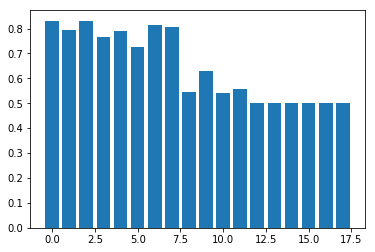

In [12]:
cv_means_df = pd.DataFrame.from_dict(cv_means)
param_combos = list(cv_means.keys())
score_vals = [cv_means[k][0] for k in param_combos]
plt.bar(range(len(param_combos)),score_vals)

In [13]:
max(score_vals)

0.8313290403081735

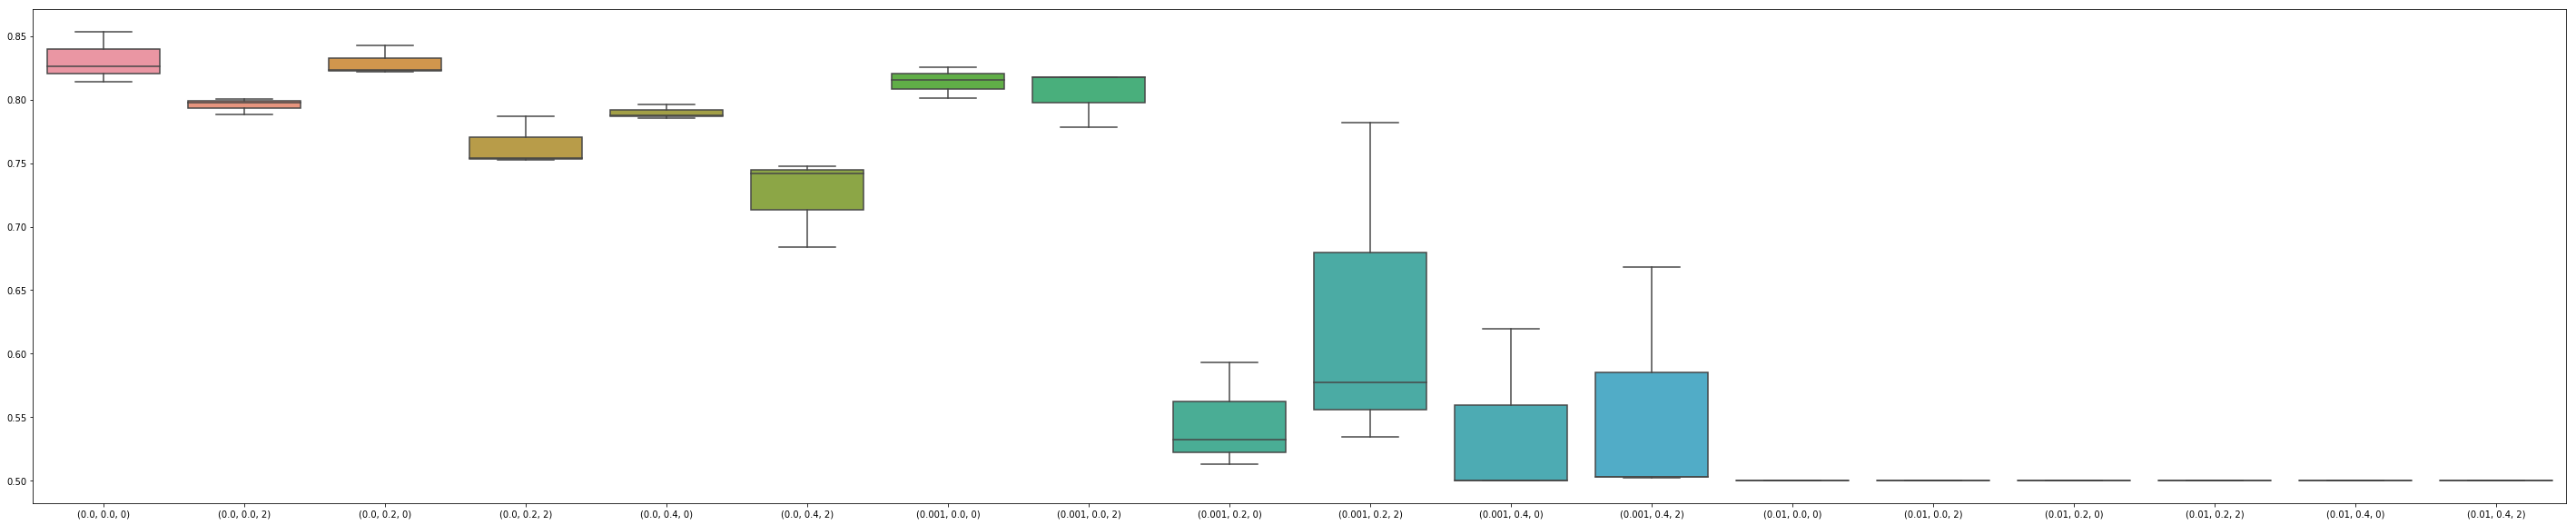

In [14]:
prec_recall_scores = []
for params in param_combos:
    folds = all_scores[params]
    prec_recall_scores.append([fold[0] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
plt.figure(figsize=(50,10))
sns.boxplot(param_combos_str, prec_recall_scores)

In [ ]:
# best => kernel_width = 3, hidden_layers = (30,), # kernels = 10

In [ ]:
all_scores[((30,), 3, 10)]

In [ ]:
aucs = []
for params in param_combos:
    folds = all_scores[params]
    aucs.append([fold[1] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
plt.figure(figsize=(50,10))
sns.boxplot(param_combos_str, aucs)

In [ ]:
conv1d(kernel_width=3,hidden_layers=(30,), num_filters=10, l2_coeff=0.0, dropout_rate=0.0,max_pool=4)